In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Thu Apr 22 08:11:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy      : 1.19.5
pandas     : 1.1.5
torch      : 1.8.1+cu101
torchvision: 0.9.1+cu101



In [ ]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_folders = sorted(glob('/content/drive/MyDrive/80:20_Datasets/80:20_train_test/*'))
len(train_folders)

5

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

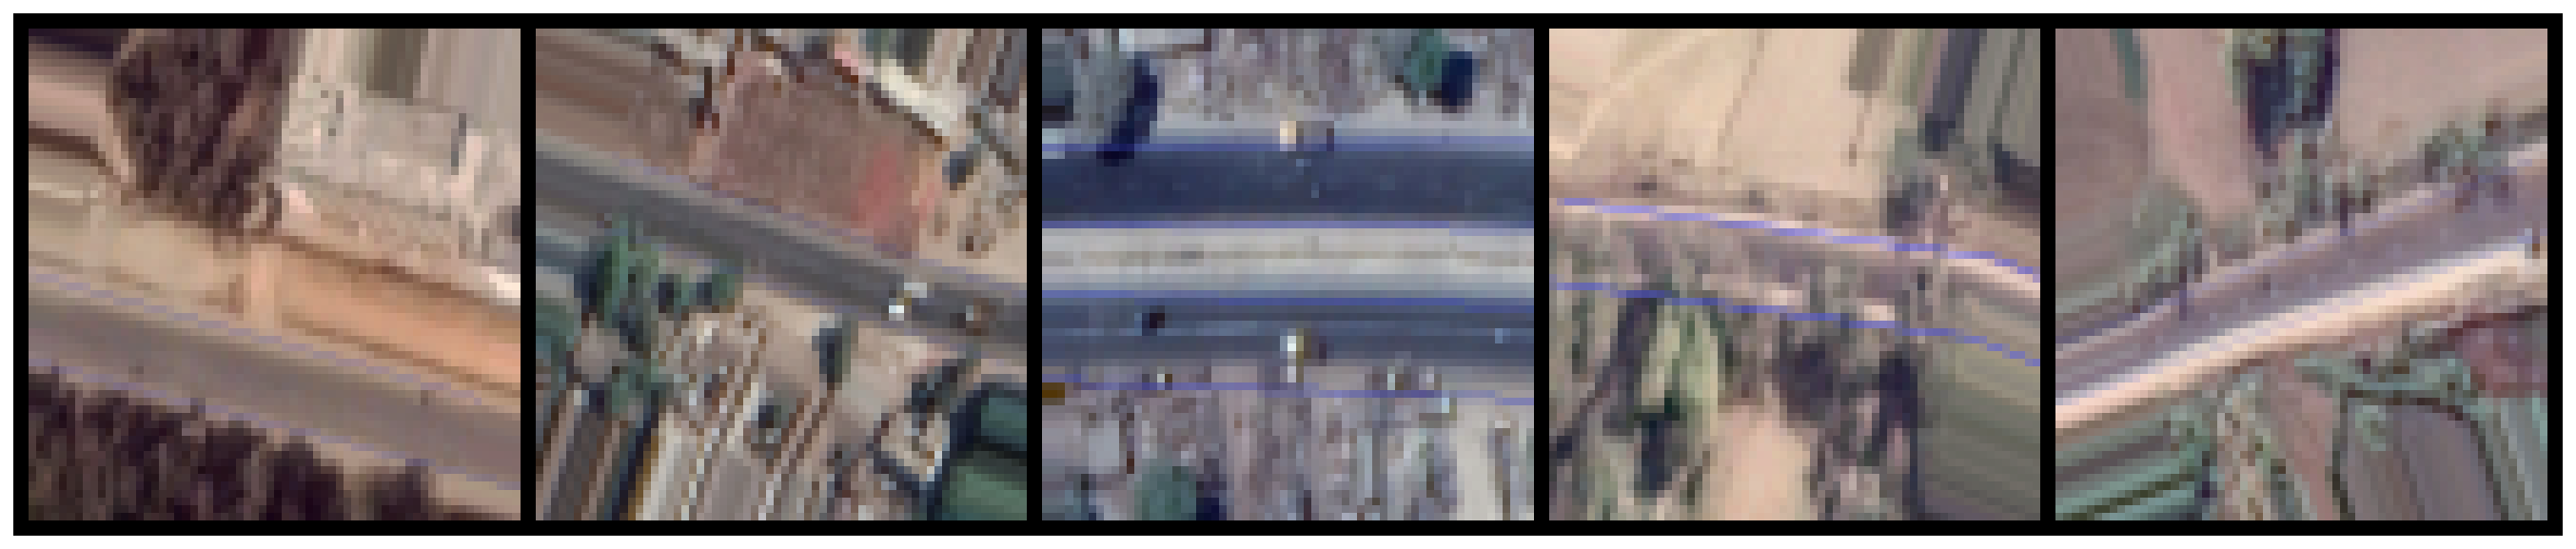

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in train_folders]
show_sign_grid(sample_images)

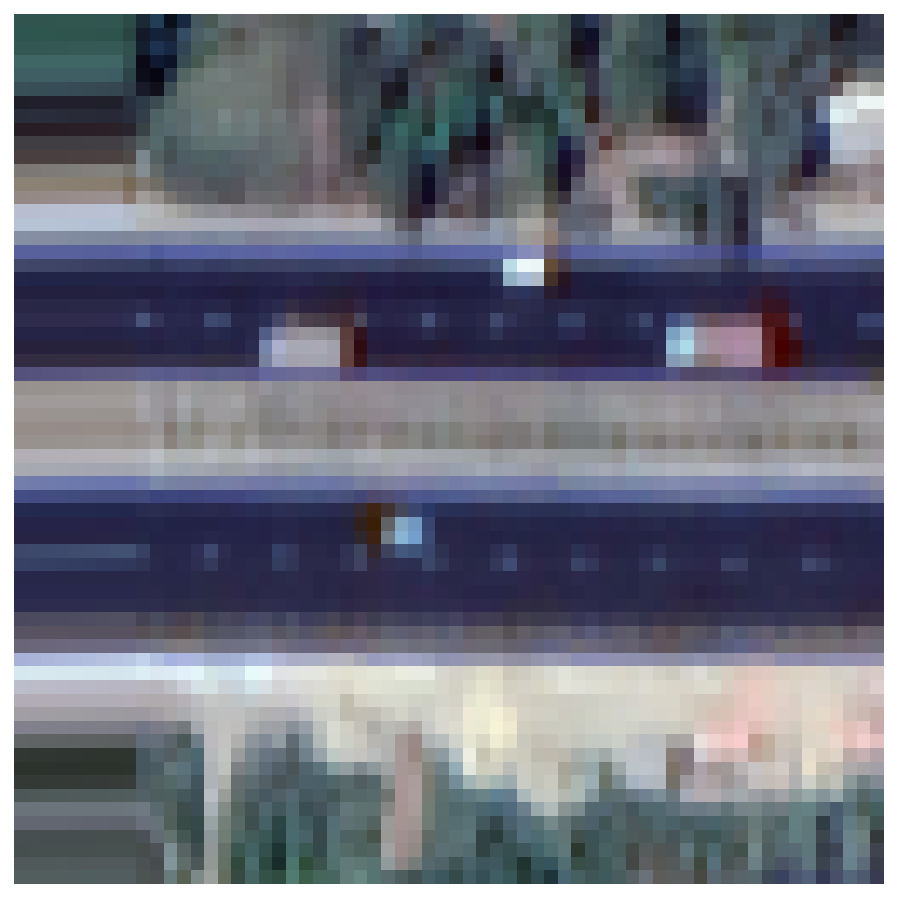

In [ ]:
img_path = glob(f'{train_folders[2]}/*png')[20]

show_image(img_path)

In [ ]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [ ]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 4788
fair: 5372
good: 5478
poor: 4945
vbad: 4249


In [ ]:
#64*64
mean_nums = [0.5, 0.5, 0.5]
std_nums = [0.5, 0.5, 0.5]

transforms = {'train': T.Compose([
  T.Resize(64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=80),
  T.CenterCrop(size=64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=64, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 19864, 'val': 4968}

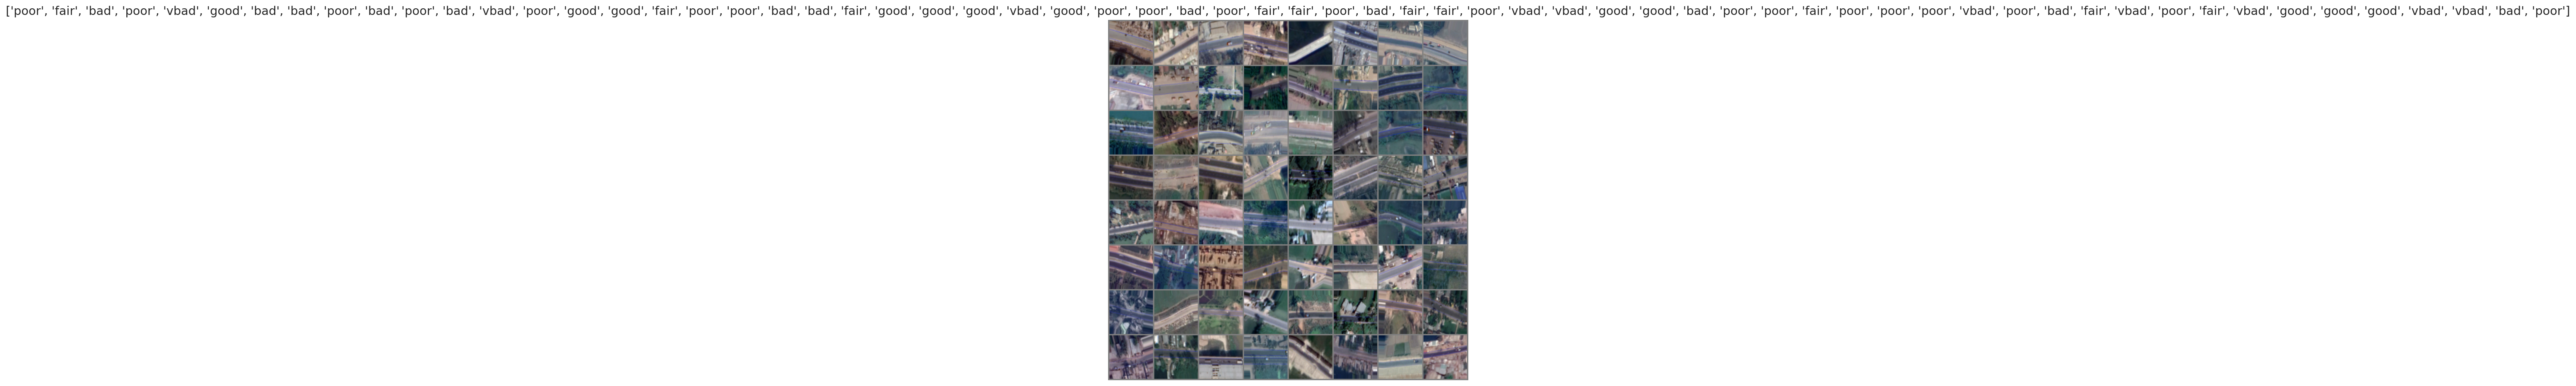

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
class RoadNet(nn.Module):
    
    def __init__(self):
        super(RoadNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
            
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256, 5)
        self.drop = nn.Dropout2d(0.2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        #out = self.layer4(out)
        out = out.view(out.size(0), -1)    # flatten out a input for Dense Layer
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc4(out)
        
        return out

In [ ]:
base_model=RoadNet()

In [ ]:
base_model.to(device)

RoadNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNor

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=30):
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [ ]:
%%time
#64*64(32)
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/30
----------
Train loss 1.2881727220547563 accuracy 0.4563028594442207
Val   loss 0.9632947315008212 accuracy 0.6022544283413849

Epoch 2/30
----------
Train loss 0.9010552399688296 accuracy 0.6405557792992348
Val   loss 0.9064133268518325 accuracy 0.6161433172302737

Epoch 3/30
----------
Train loss 0.8027115406621481 accuracy 0.6779601288763593
Val   loss 0.8621845875795071 accuracy 0.643317230273752

Epoch 4/30
----------
Train loss 0.7455327166259385 accuracy 0.7062021747885623
Val   loss 0.7378992465062019 accuracy 0.6972624798711755

Epoch 5/30
----------
Train loss 0.6962230365825353 accuracy 0.7266915022150624
Val   loss 0.7607007861519471 accuracy 0.6835748792270532

Epoch 6/30
----------
Train loss 0.6461963574379539 accuracy 0.7465263793797825
Val   loss 0.7796328207239126 accuracy 0.6805555555555556

Epoch 7/30
----------
Train loss 0.6137322678850085 accuracy 0.7584071687474829
Val   loss 0.7454527643246528 accuracy 0.6988727858293076

Epoch 8/30
----------
Train 

In [ ]:
%%time
#64*64(64)
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/30
----------
Train loss 1.2551271727614082 accuracy 0.4706504228755538
Val   loss 0.9508767364880978 accuracy 0.6082930756843801

Epoch 2/30
----------
Train loss 0.8506130440058816 accuracy 0.6595348368908579
Val   loss 0.791761230199765 accuracy 0.6757246376811594

Epoch 3/30
----------
Train loss 0.7407632226729316 accuracy 0.7025271848570278
Val   loss 0.8262164042546198 accuracy 0.6477455716586151

Epoch 4/30
----------
Train loss 0.6833214710954685 accuracy 0.7267921868707209
Val   loss 1.0191349043295934 accuracy 0.6024557165861514

Epoch 5/30
----------
Train loss 0.6203281613024868 accuracy 0.752517116391462
Val   loss 0.7149581213792165 accuracy 0.7083333333333334

Epoch 6/30
----------
Train loss 0.5692921725500052 accuracy 0.7733588401127669
Val   loss 0.6961215814718833 accuracy 0.7163848631239935

Epoch 7/30
----------
Train loss 0.5266052936817672 accuracy 0.7938985098670963
Val   loss 0.6422294836777908 accuracy 0.7435587761674718

Epoch 8/30
----------
Train l

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

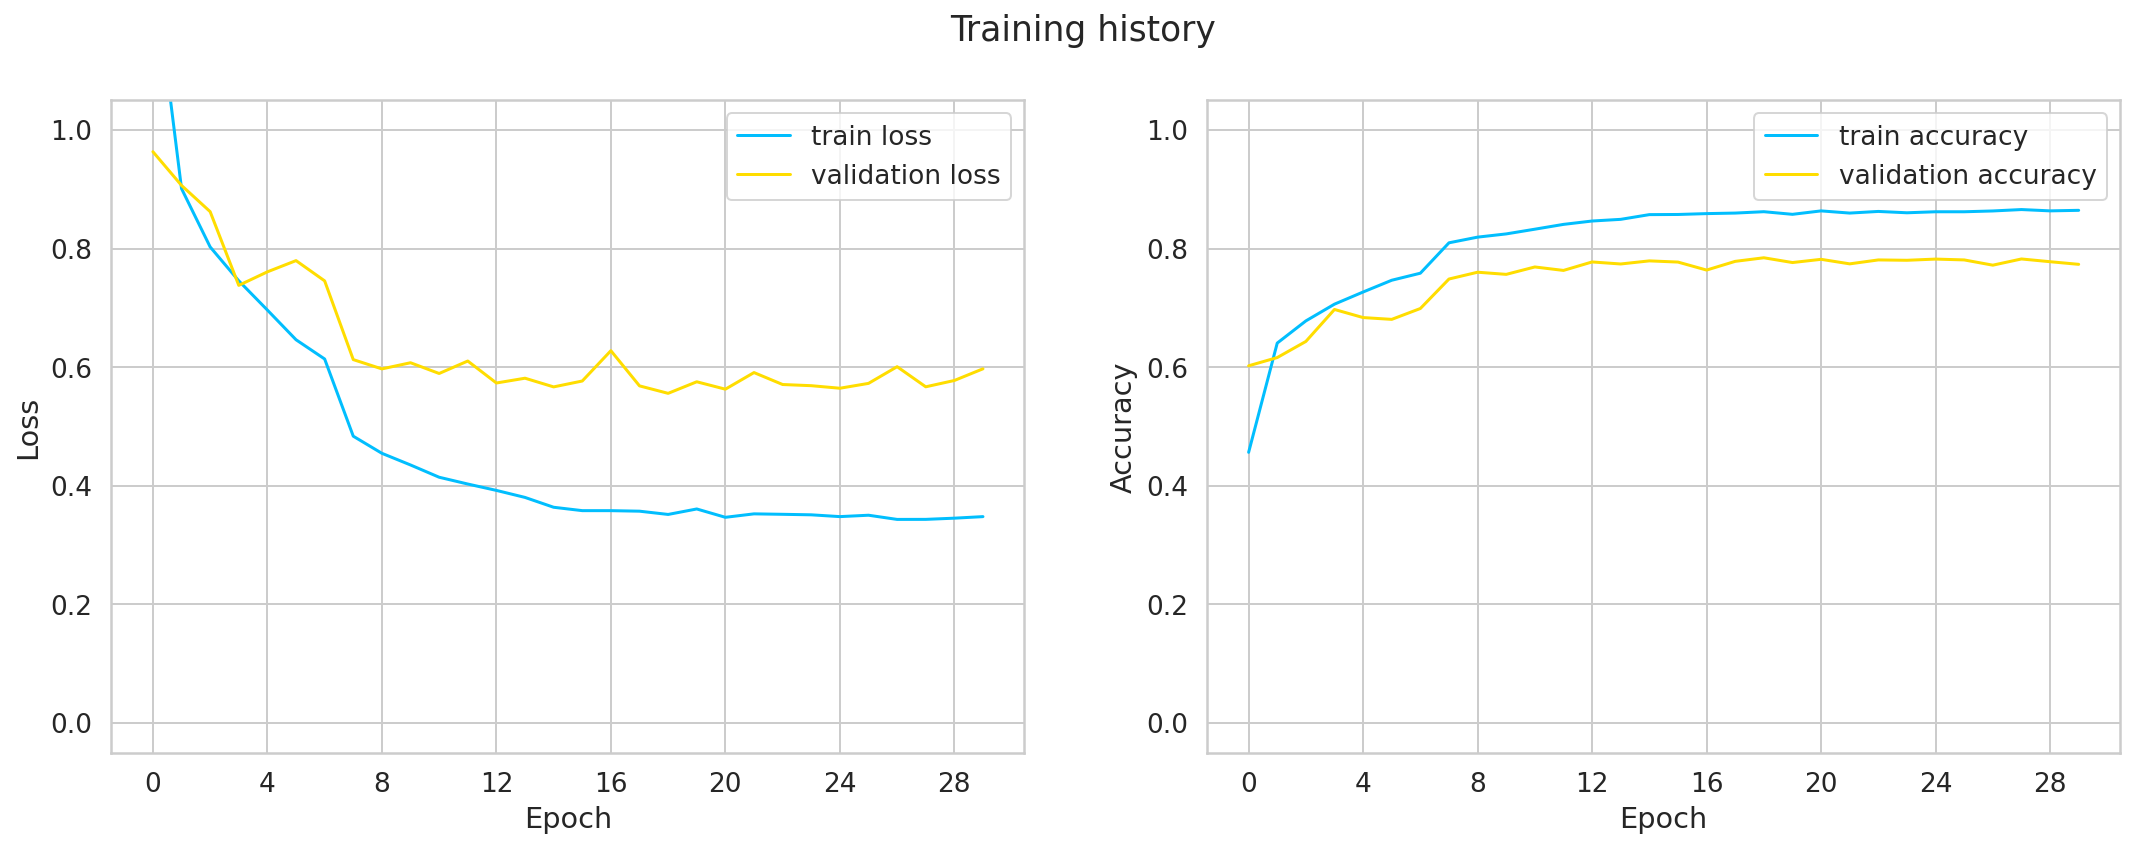

In [ ]:
#64*64
plot_training_history(history)

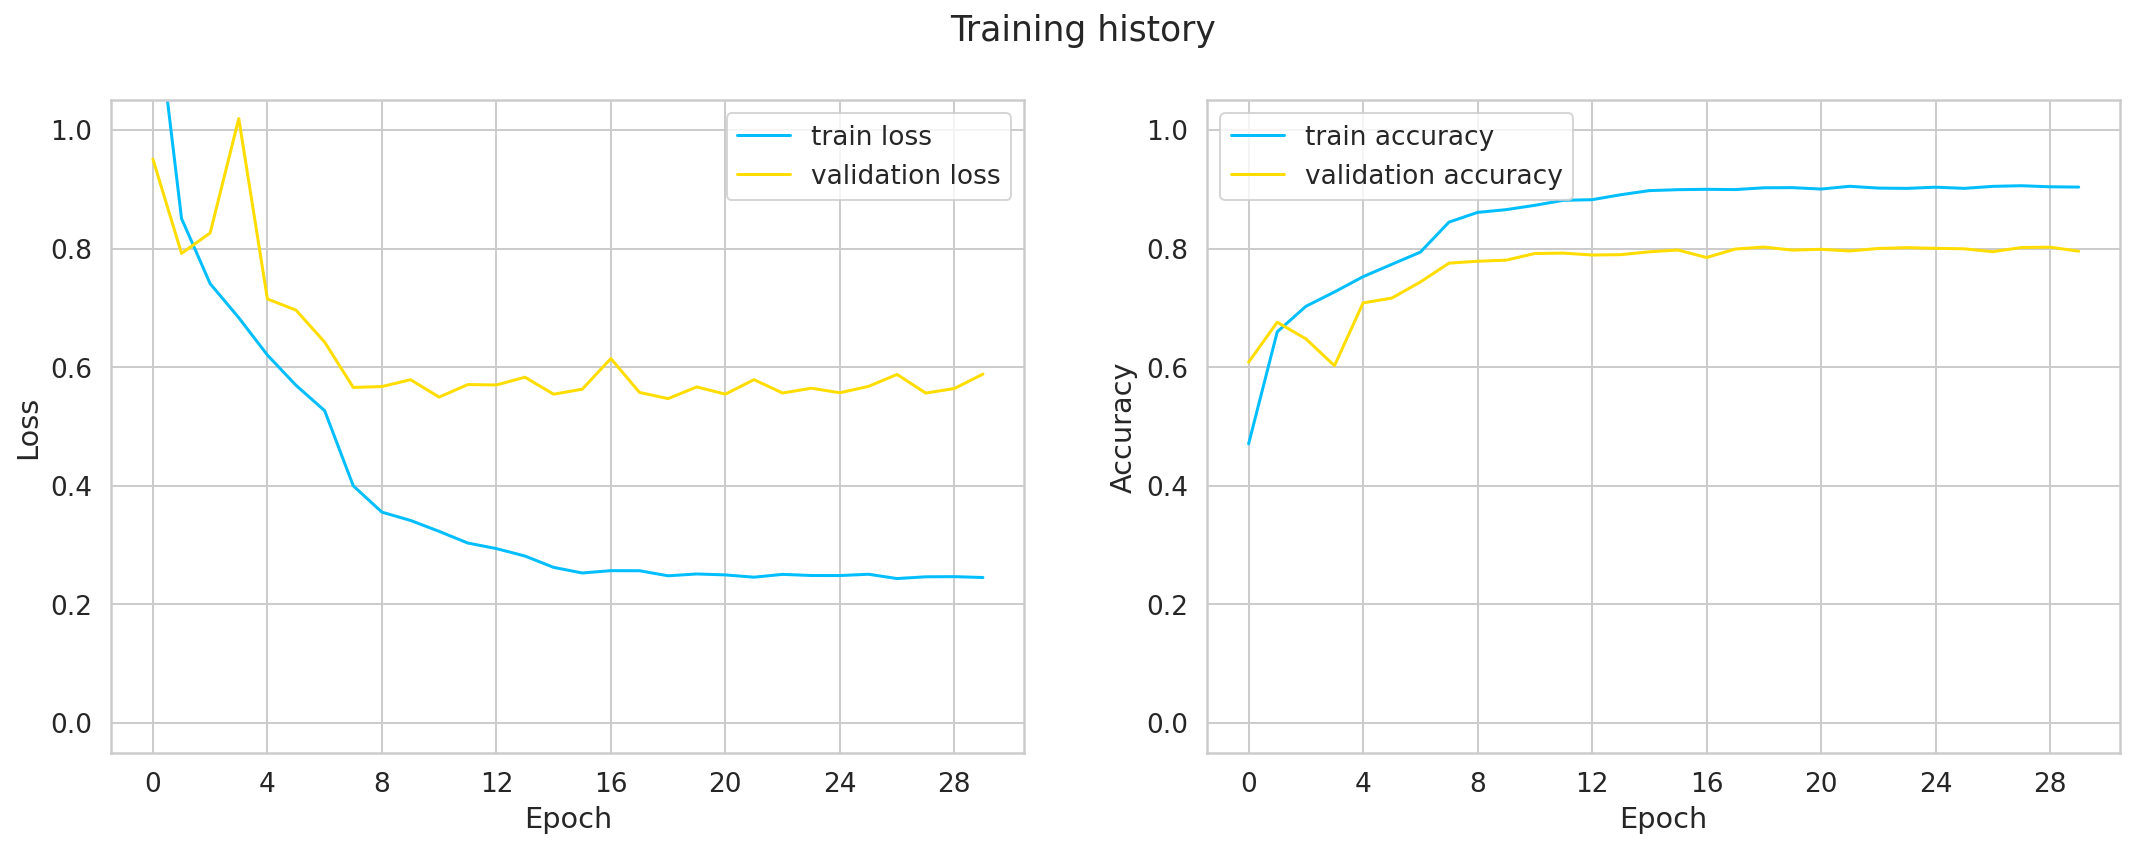

In [ ]:
#64*64
plot_training_history(history)

# **Test Data**(unseen)

In [ ]:
test_folders = sorted(glob('/content/drive/MyDrive/80:20_Datasets/test_set/*'))
len(test_folders)

5

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

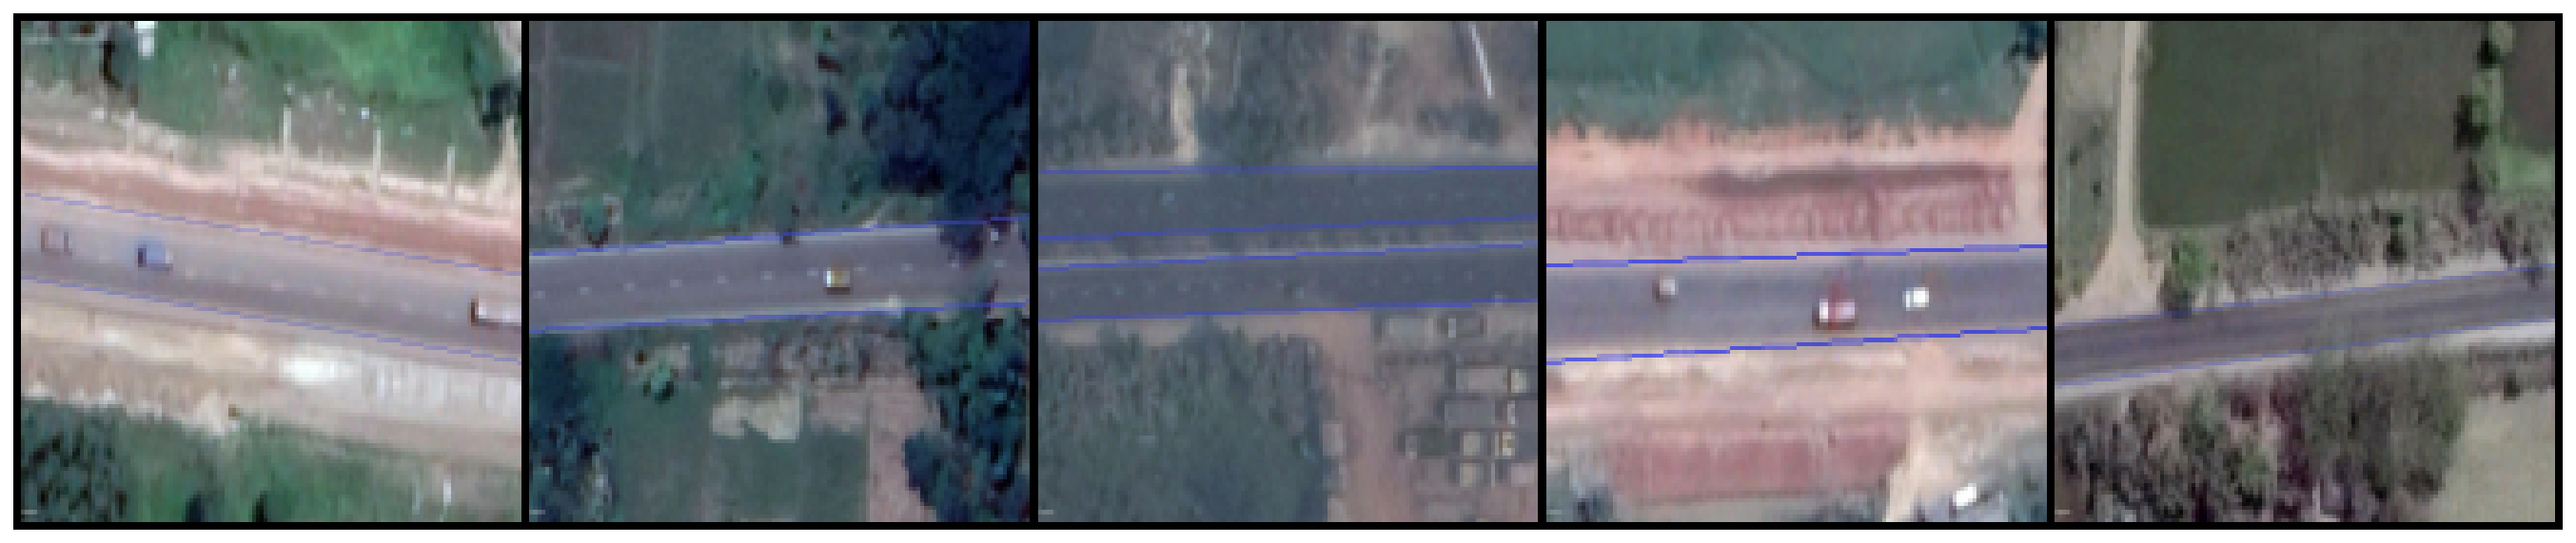

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in test_folders]
show_sign_grid(sample_images)

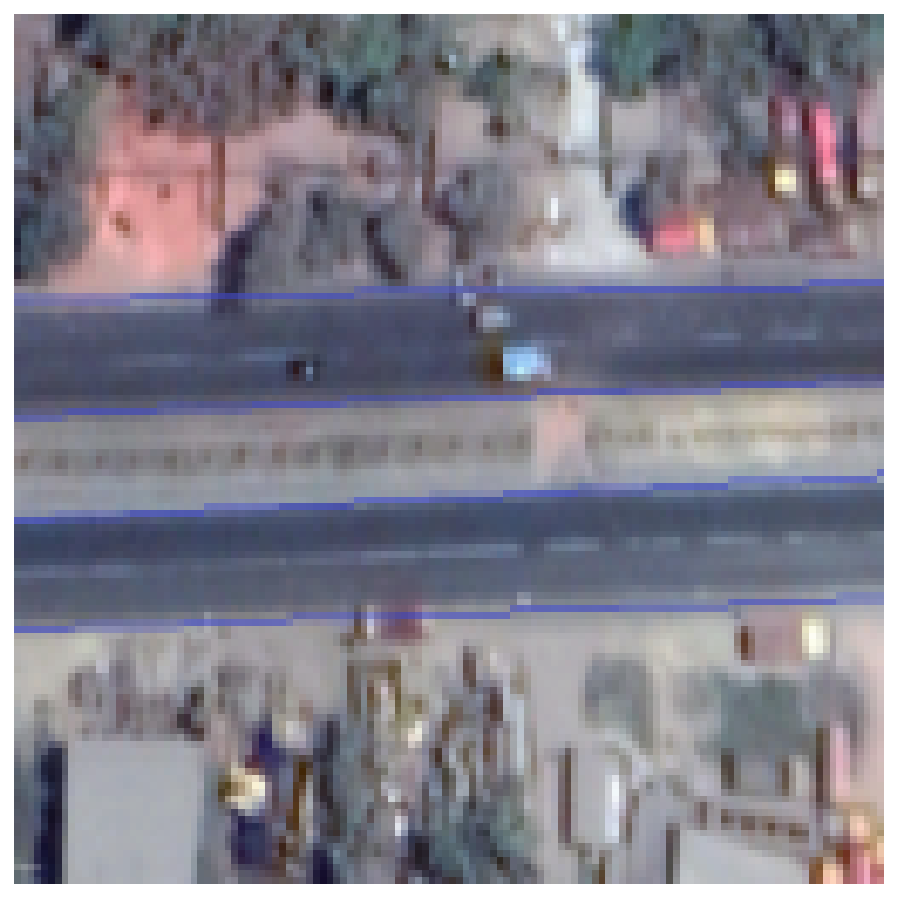

In [ ]:
img_path = glob(f'{test_folders[2]}/*png')[1]

show_image(img_path)

In [ ]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [ ]:
!rm -rf data

DATA_DIR = Path('test_data')

DATASETS = ['test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{test_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 171
fair: 205
good: 200
poor: 180
vbad: 157


In [ ]:
#64*64
mean_nums = [0.5, 0.5, 0.5]
std_nums = [0.5, 0.5, 0.5]

transforms = {'test': T.Compose([
  T.Resize(size=80),
  T.CenterCrop(size=64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=32, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

{'test': 913}

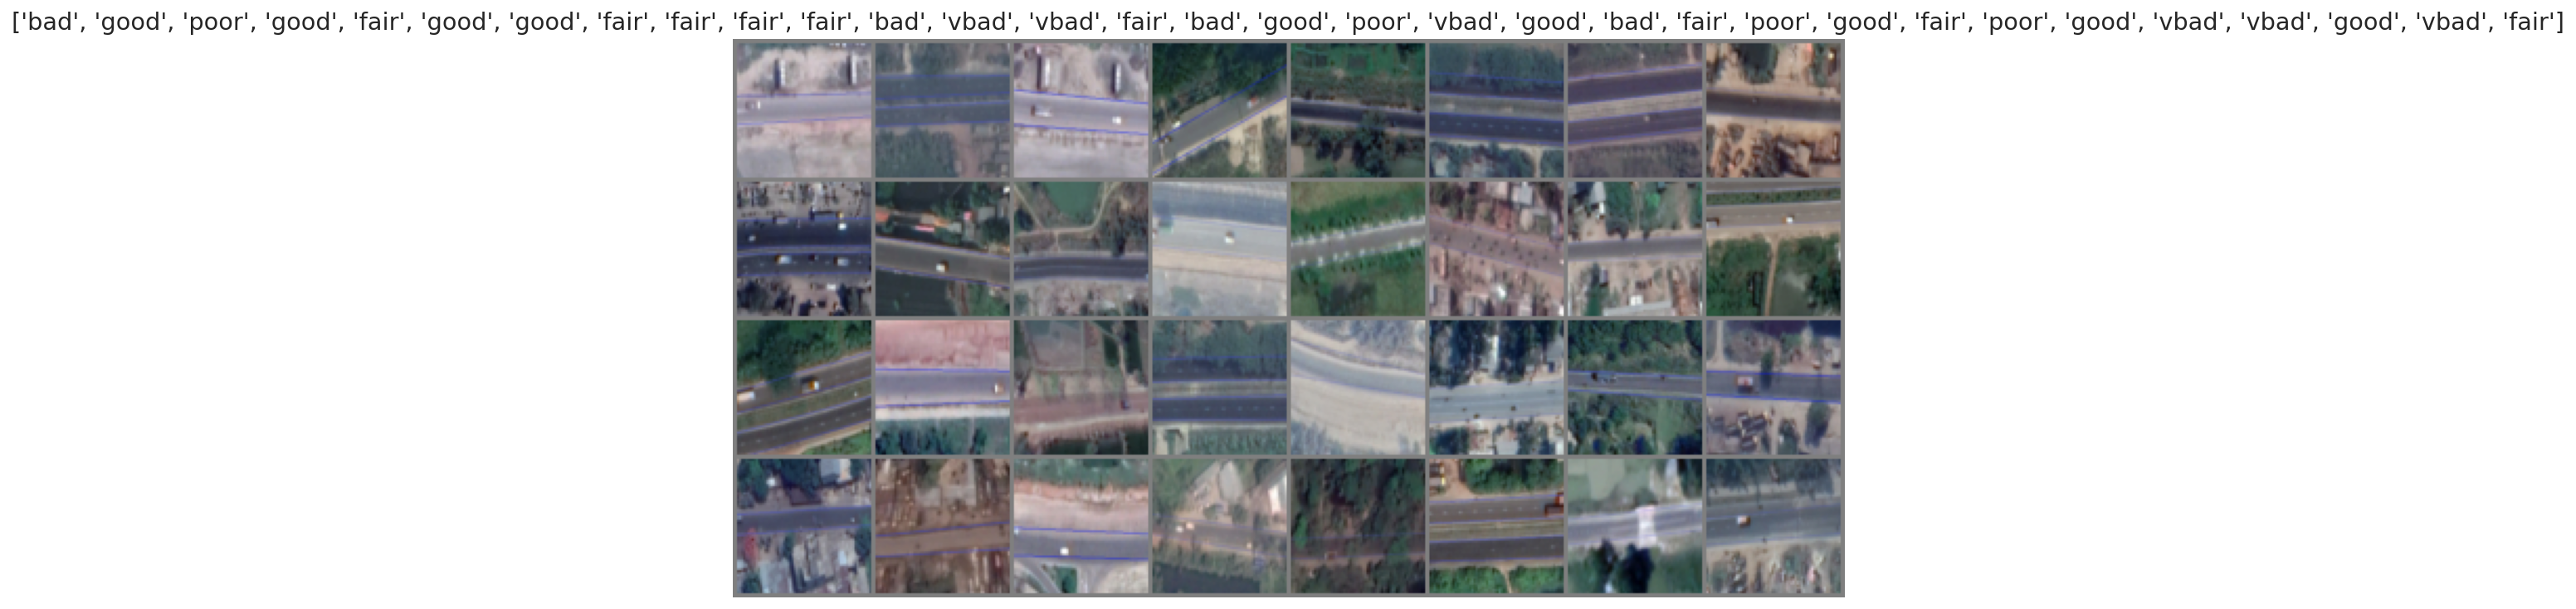

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure(figsize=(20,10))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}\n'  f'true: {class_names[labels[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

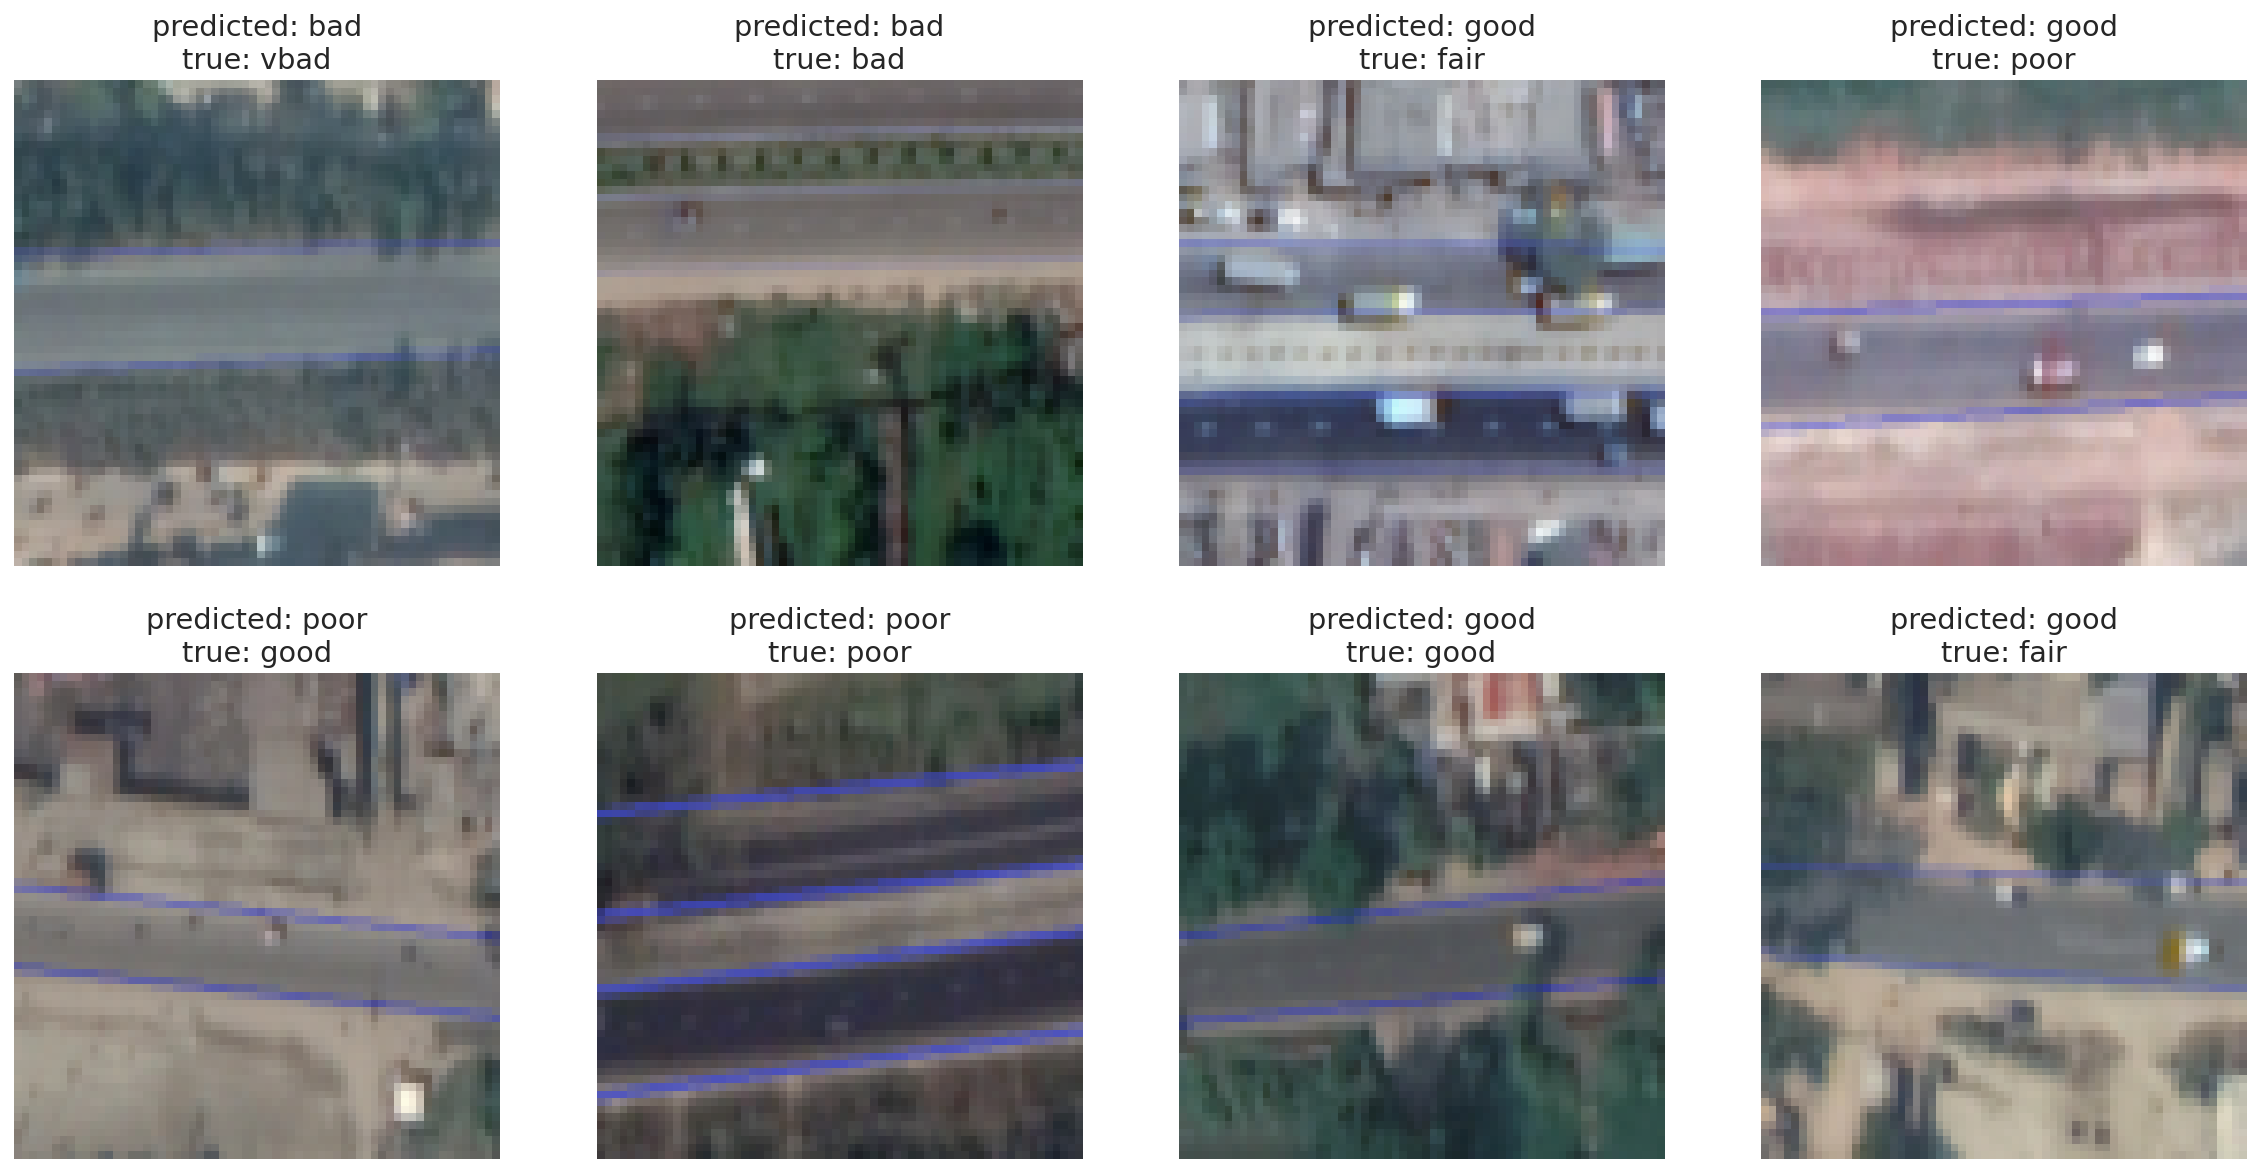

In [ ]:
show_predictions(base_model, class_names, n_images=8)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [ ]:
#64*64
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.76      0.75      0.76       171
        fair       0.80      0.55      0.65       205
        good       0.67      0.82      0.74       200
        poor       0.79      0.82      0.80       180
        vbad       0.67      0.73      0.70       157

    accuracy                           0.73       913
   macro avg       0.74      0.73      0.73       913
weighted avg       0.74      0.73      0.73       913



In [ ]:
#64*64(64)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.72      0.72      0.72       171
        fair       0.78      0.53      0.63       205
        good       0.68      0.81      0.74       200
        poor       0.81      0.80      0.80       180
        vbad       0.66      0.77      0.71       157

    accuracy                           0.72       913
   macro avg       0.73      0.73      0.72       913
weighted avg       0.73      0.72      0.72       913



In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

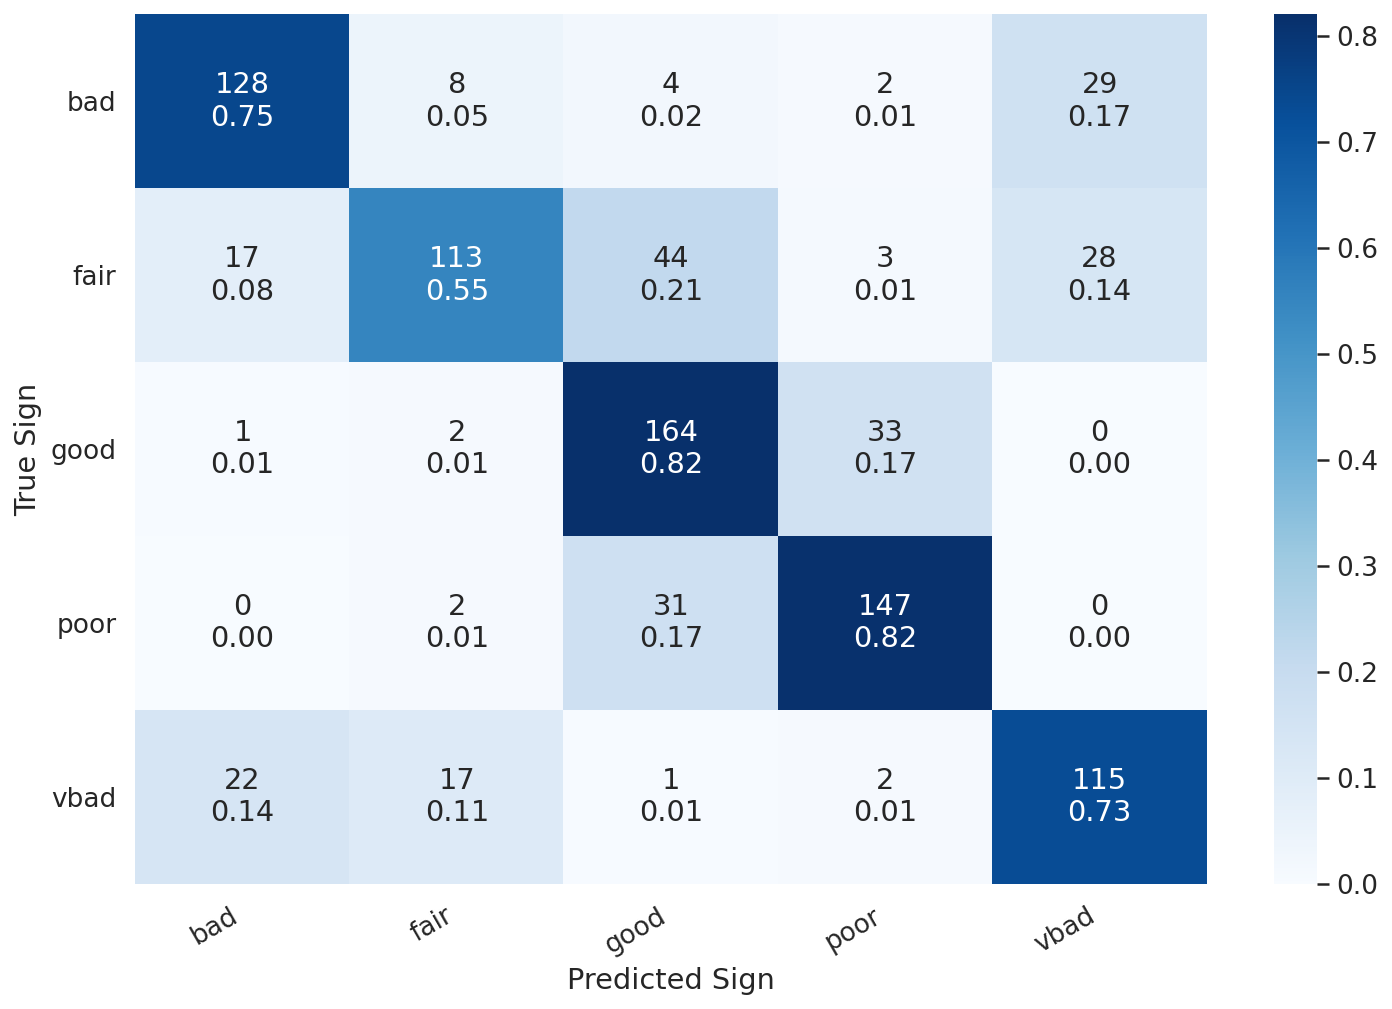

In [ ]:
#64*64
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

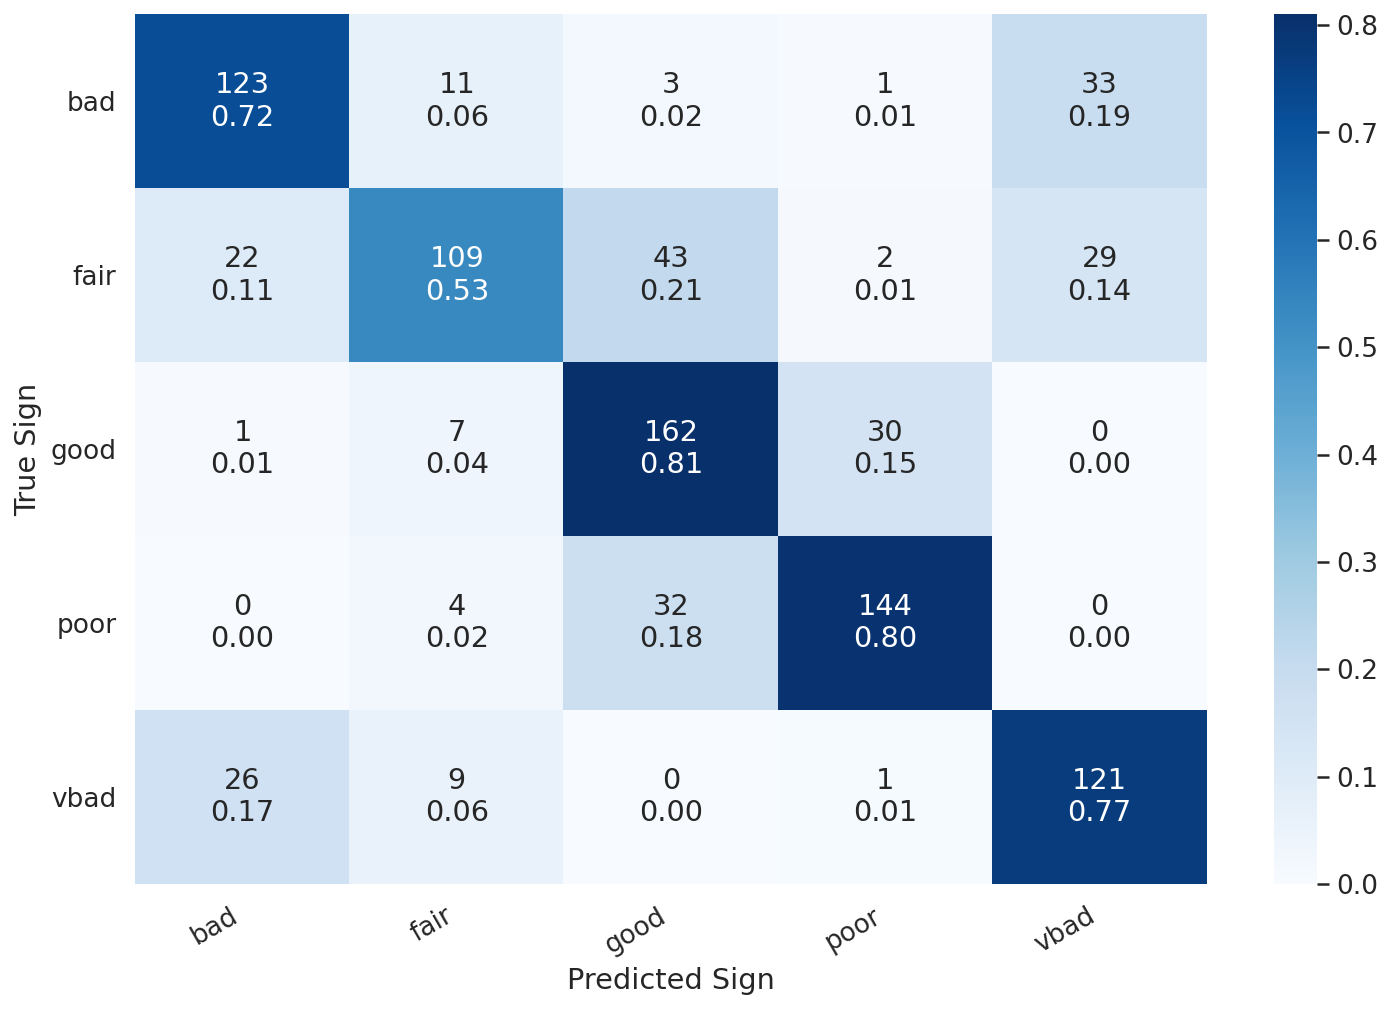

In [ ]:
#64*64(64)
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

# **Hold out dataset(New Road for testing)**

In [ ]:
held_folders = sorted(glob('/content/drive/MyDrive/heldoutV2/*'))
len(held_folders)

5

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

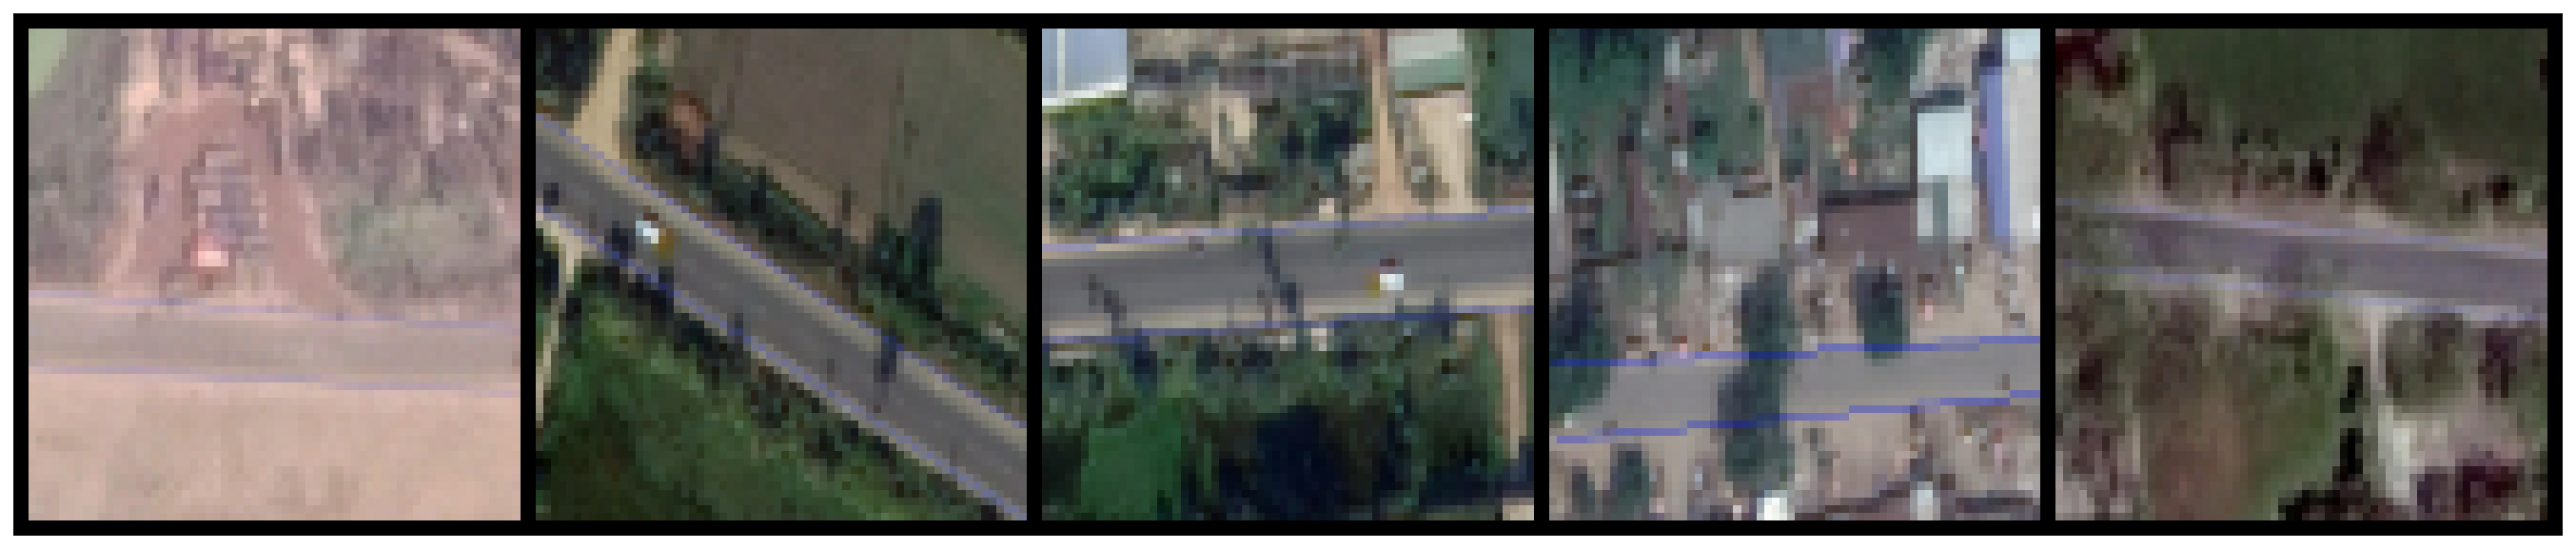

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in held_folders]
show_sign_grid(sample_images)

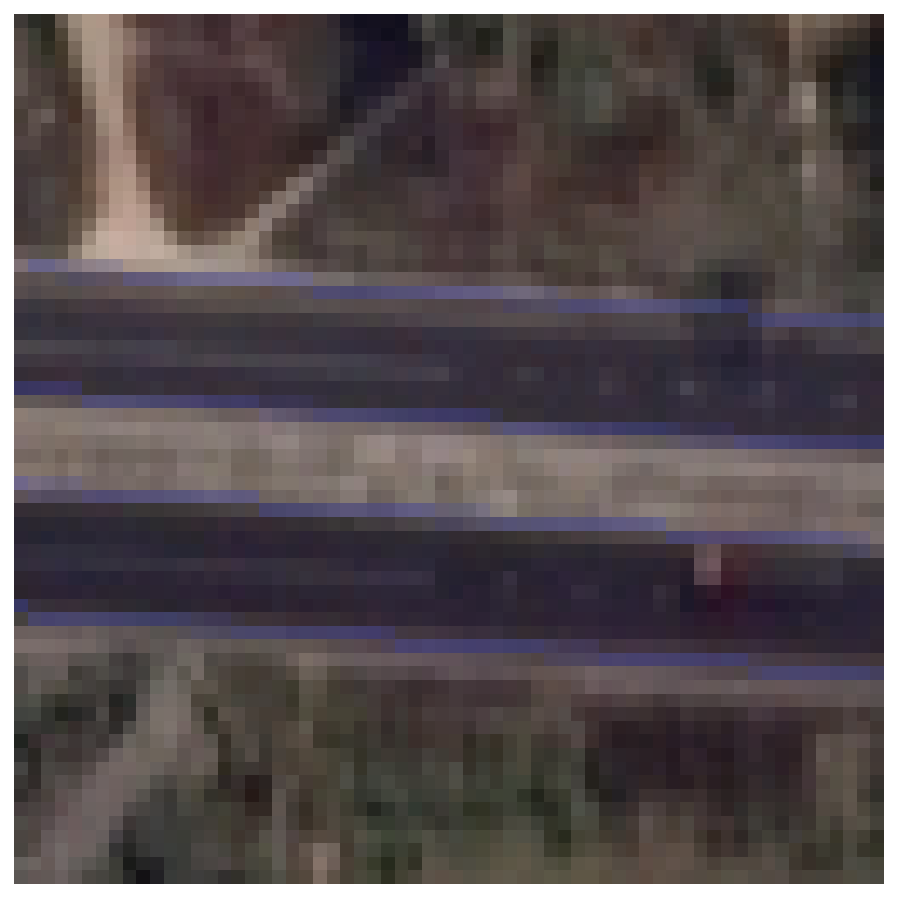

In [ ]:
img_path = glob(f'{held_folders[2]}/*png')[20]

show_image(img_path)

In [ ]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [ ]:
!rm -rf data

DATA_DIR = Path('heldout_data')

DATASETS = ['heldout_test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{held_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 104
fair: 115
good: 113
poor: 91
vbad: 94


In [ ]:
#64*64
mean_nums = [0.5, 0.5, 0.5]
std_nums = [0.5, 0.5, 0.5]

transforms = {'heldout_test': T.Compose([
  T.Resize(size=80),
  T.CenterCrop(size=64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'heldout_test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=10, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['heldout_test'].classes

dataset_sizes

{'heldout_test': 517}

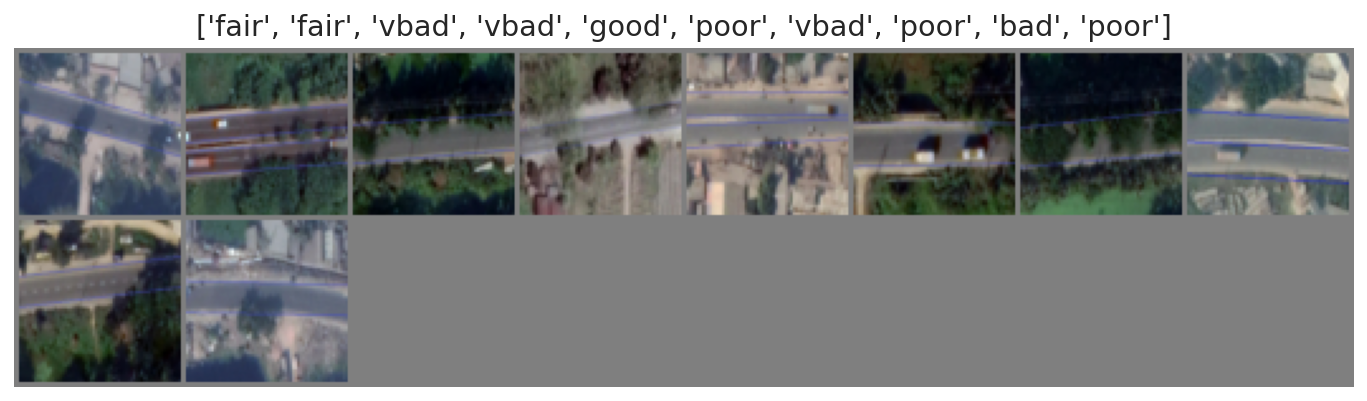

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['heldout_test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['heldout_test'])

In [ ]:
#64*64
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.57      0.64      0.61       104
        fair       0.36      0.48      0.41       115
        good       0.42      0.36      0.39       113
        poor       0.58      0.45      0.51        91
        vbad       0.76      0.65      0.70        94

    accuracy                           0.51       517
   macro avg       0.54      0.52      0.52       517
weighted avg       0.53      0.51      0.52       517



In [ ]:
#64*64(64)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.56      0.59      0.58       104
        fair       0.42      0.64      0.51       115
        good       0.47      0.35      0.40       113
        poor       0.67      0.43      0.52        91
        vbad       0.73      0.71      0.72        94

    accuracy                           0.54       517
   macro avg       0.57      0.54      0.55       517
weighted avg       0.56      0.54      0.54       517



In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

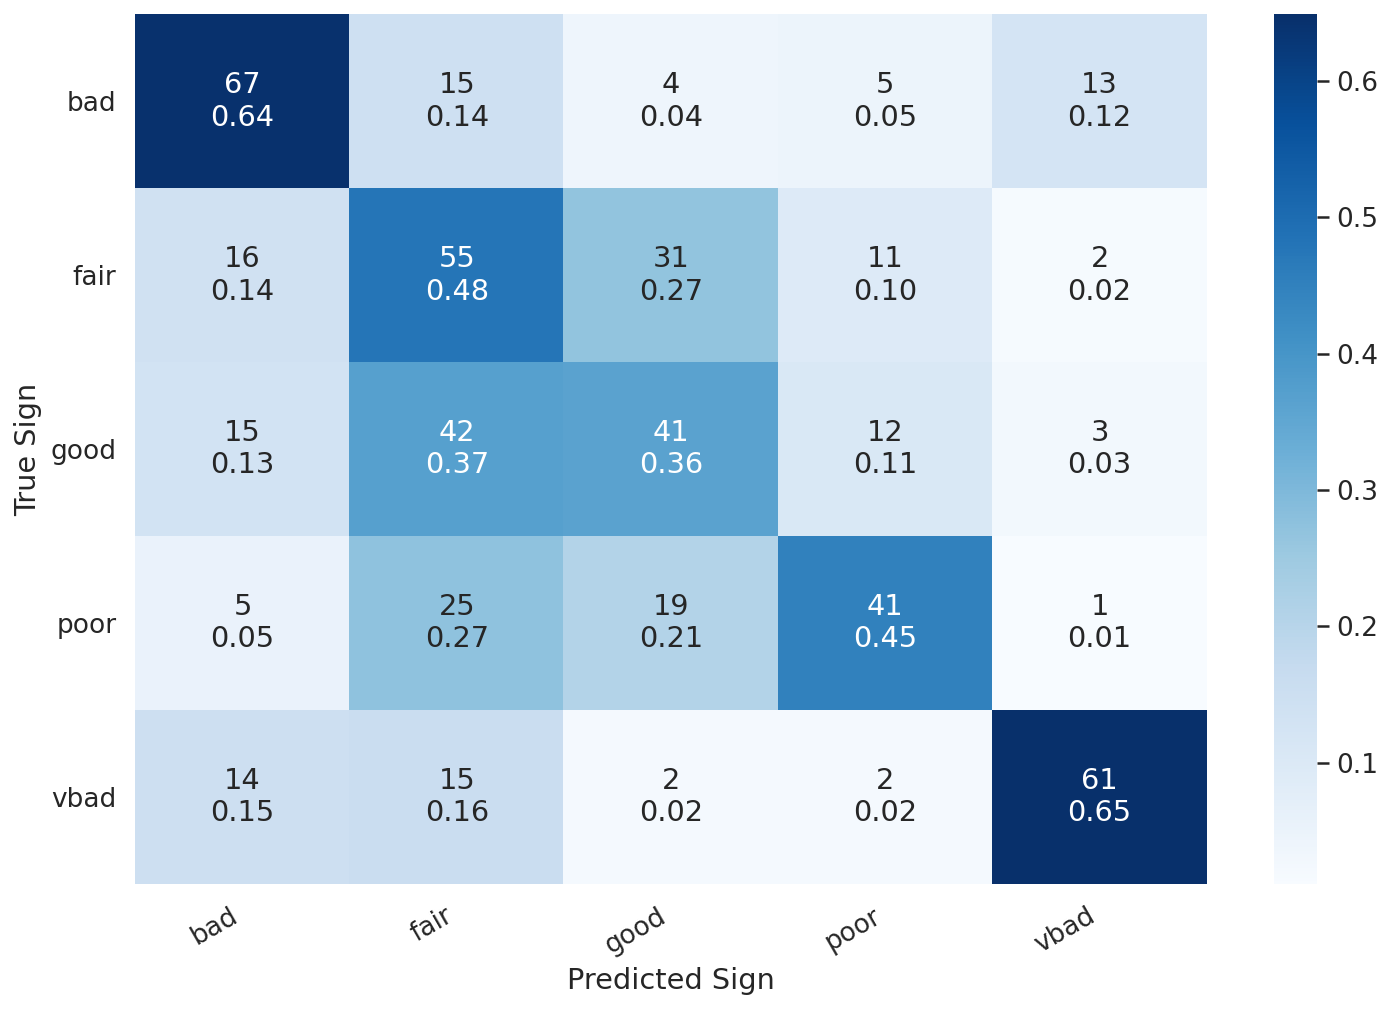

In [ ]:
#64*64
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

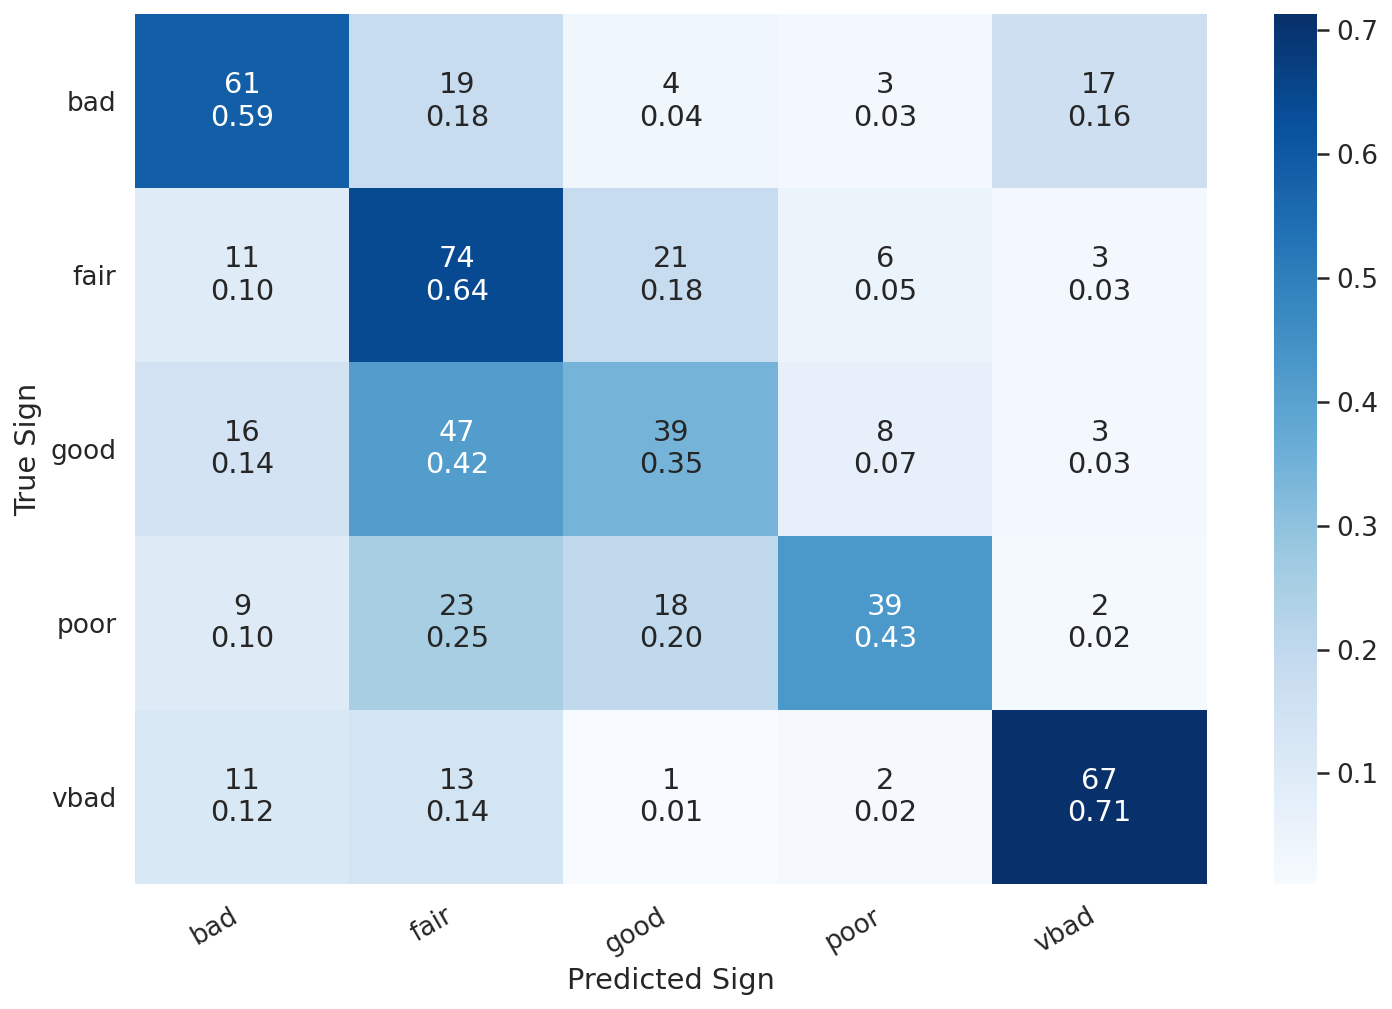

In [ ]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

In [ ]:
root_path = '/content/drive/My Drive/'

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(base_model.state_dict(), root_path + 'Cnn802064.pkl') 

In [ ]:
load_model = True

if load_model is True:
    base_model.load_state_dict(torch.load(root_path + 'Cnn802032.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

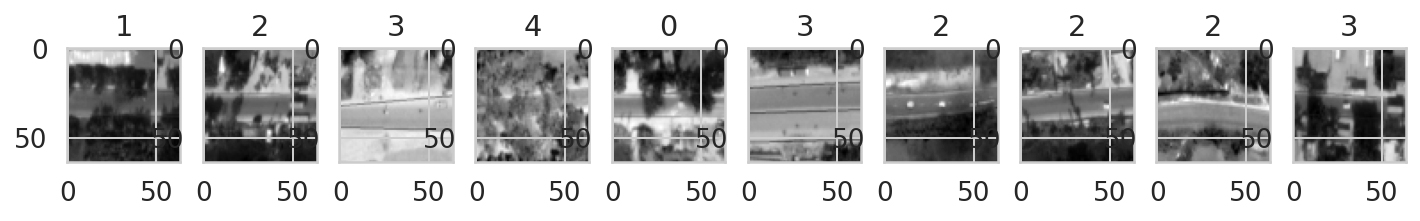

In [ ]:
for images, labels in data_loaders['heldout_test']:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    show_img = images[i][0].numpy().reshape(64, 64)
    ax[i].imshow(show_img,cmap='gray')
    ax[i].set_title(int(labels[i]))
    
plt.show()

In [ ]:
predictions = base_model.forward(images[:10].view(-1, 3,64,64).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [2 1 3 4 2 2 2 1 4 1]


# 224*224

In [ ]:
load_model = True

if load_model is True:
    base_model.load_state_dict(torch.load(root_path + 'Cnn802064.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

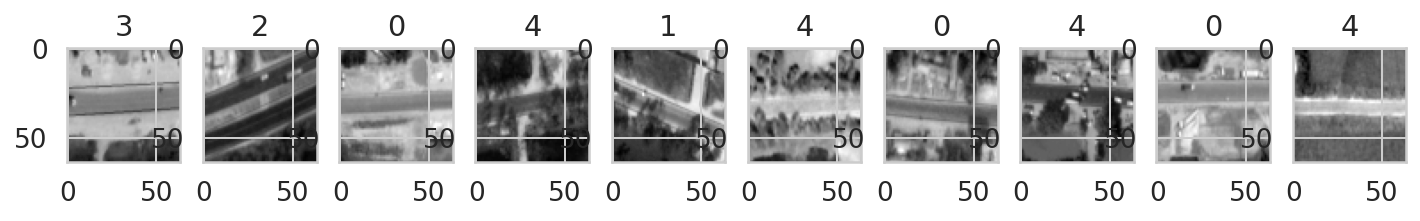

In [ ]:
for images, labels in data_loaders['heldout_test']:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    show_img = images[i][0].numpy().reshape(64, 64)
    ax[i].imshow(show_img,cmap='gray')
    ax[i].set_title(int(labels[i]))
    
plt.show()

In [ ]:
predictions = base_model.forward(images[:10].view(-1, 3,64,64).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [2 2 0 4 4 4 4 1 0 4]
